In [1]:
!ls -R

.:
6gj7_copy.pdbqt       docking.ipynb   ligand_F0B.sdf
6gj7_fix_clean.pdbqt  left_molecules  README.md

./left_molecules:
dragonfly_biased_smiles_left_mols.csv
dragonfly_unbiased_smiles_left_mols.csv
edm_10000_mols_smiles_left_mols.csv
hiergraph_10000_mols_smiles_left_mols.csv
jtvae_10000_mols_smiles_left_mols.csv
microsoft_10000_smiles_left_mols.csv
molfinder_10000_mols_smiles_left_mols.csv
molgpt_10000_mols_smiles_left_mols.csv
pilot_10000_smiles_left_mols.csv
pocket2mol_10000_mols_smiles_left_mols.csv
reinvent4_TL584_chpt200_10000_mols_smiles_left_mols.csv
reinvent4_vanilla.csv
resgen_10000_mols_smiles_left_mols.csv
targetdiff_10000_mols_smiles_left_mols.csv
tgmdlm_10000_mols_smiles_left_mols.csv


In [6]:
from pathlib import Path
import subprocess
import pandas as pd
import datamol as dm
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

dm.disable_rdkit_log()

left_dir = Path("left_molecules")
output_root = Path("pdbqt_ready")
output_root.mkdir(parents=True, exist_ok=True)

def _worker(i, smi, csv_stem, out_dir):
    dm.disable_rdkit_log()
    if not smi or not isinstance(smi, str):
        return False
    mol = dm.to_mol(smi, ordered=True)
    if mol is None or mol.GetNumAtoms() == 0:
        return False
    mol = dm.fix_mol(mol)
    if mol is None or mol.GetNumAtoms() == 0:
        return False
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    if mol is None or mol.GetNumAtoms() == 0:
        return False
    mol = dm.standardize_mol(mol, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True)
    if mol is None or mol.GetNumAtoms() == 0:
        return False
    mol = Chem.AddHs(mol)
    if mol is None or mol.GetNumAtoms() == 0:
        return False
    emb_res = AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    if emb_res != 0:
        return False
    AllChem.MMFFOptimizeMolecule(mol)
    if mol.GetNumConformers() == 0:
        return False

    tmp = out_dir / f"{csv_stem}_{i:05d}.sdf"
    Chem.MolToMolFile(mol, str(tmp))
    if not tmp.exists() or tmp.stat().st_size == 0:
        return False

    out_file = out_dir / f"{csv_stem}_{i:05d}.pdbqt"
    result = subprocess.run(
        ["obabel", "-isdf", str(tmp), "-opdbqt", "-O", str(out_file)],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )
    tmp.unlink(missing_ok=True)
    if result.returncode != 0:
        return False
    if not out_file.exists() or out_file.stat().st_size == 0:
        out_file.unlink(missing_ok=True)
        return False
    return True

for csv_path in sorted(left_dir.glob("*.csv")):
    df = pd.read_csv(csv_path, usecols=[0], dtype=str)
    smiles = df.iloc[:, 0].fillna("")
    out_dir = output_root / csv_path.stem
    out_dir.mkdir(parents=True, exist_ok=True)
    tasks = [(idx, smi, csv_path.stem, out_dir) for idx, smi in enumerate(smiles, 1)]
    results = dm.parallelized(_worker, tasks, arg_type="args", n_jobs=-1, progress=True)
    print(f"{csv_path.name}: {sum(results)}/{len(results)} molecules converted")


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


dragonfly_biased_smiles_left_mols.csv: 2/2 molecules converted


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


dragonfly_biased_with_affinity.csv: 2/2 molecules converted


100%|██████████| 2015/2015 [00:14<00:00, 140.31it/s] 


dragonfly_unbiased_smiles_left_mols.csv: 2013/2015 molecules converted


100%|██████████| 404/404 [00:00<00:00, 801.25it/s]


edm_10000_mols_smiles_left_mols.csv: 404/404 molecules converted


100%|██████████| 3396/3396 [00:03<00:00, 981.58it/s] 


hiergraph_10000_mols_smiles_left_mols.csv: 3390/3396 molecules converted


100%|██████████| 5840/5840 [00:18<00:00, 320.80it/s] 


jtvae_10000_mols_smiles_left_mols.csv: 5825/5840 molecules converted


100%|██████████| 3034/3034 [00:07<00:00, 379.31it/s] 


microsoft_10000_smiles_left_mols.csv: 3030/3034 molecules converted


100%|██████████| 2503/2503 [00:03<00:00, 813.42it/s] 


molfinder_10000_mols_smiles_left_mols.csv: 2503/2503 molecules converted


100%|██████████| 2984/2984 [00:03<00:00, 847.39it/s] 


molgpt_10000_mols_smiles_left_mols.csv: 2984/2984 molecules converted


100%|██████████| 2364/2364 [00:08<00:00, 277.19it/s] 


pilot_10000_smiles_left_mols.csv: 2362/2364 molecules converted


100%|██████████| 1552/1552 [00:01<00:00, 792.16it/s] 


pocket2mol_10000_mols_smiles_left_mols.csv: 1552/1552 molecules converted


100%|██████████| 1032/1032 [00:05<00:00, 185.34it/s]


reinvent4_TL584_chpt200_10000_mols_smiles_left_mols.csv: 1028/1032 molecules converted


100%|██████████| 3893/3893 [00:04<00:00, 857.01it/s] 


reinvent4_vanilla.csv: 3893/3893 molecules converted


100%|██████████| 470/470 [00:00<00:00, 498.32it/s]


resgen_10000_mols_smiles_left_mols.csv: 470/470 molecules converted


100%|██████████| 683/683 [00:00<00:00, 828.78it/s] 


targetdiff_10000_mols_smiles_left_mols.csv: 683/683 molecules converted


100%|██████████| 675/675 [00:10<00:00, 64.91it/s] 

tgmdlm_10000_mols_smiles_left_mols.csv: 669/675 molecules converted


In [8]:
from pathlib import Path
import pandas as pd

def extract_best_affinity(log_path):
    with open(log_path, encoding='utf-8') as f:
        lines = f.readlines()
    start = False
    for line in lines:
        if line.strip().startswith('mode'):
            start = True
            continue
        if start and line.strip() and line[0].isdigit():
            try:
                parts = line.split()
                return float(parts[1])
            except Exception:
                return None
    return None

def clean_dir_name(name):
    for suffix in [
        "_10000_mols_smiles_left_mols",
        "_smiles_left_mols",
        "_left_mols",
    ]:
        if name.endswith(suffix):
            name = name[: -len(suffix)]
    return name

def find_result_dir(csv_path, docking_root):
    stem = clean_dir_name(csv_path.stem)
    candidate = docking_root / stem
    if candidate.exists():
        return candidate
    for subdir in docking_root.iterdir():
        if subdir.is_dir() and stem in subdir.name:
            return subdir
    return None

def collect_affinities(csv_path, docking_dir, output_csv):
    df = pd.read_csv(csv_path, usecols=[0], dtype=str)
    n = len(df)
    affinities = []
    for idx in range(1, n + 1):
        pattern = f"*_{idx:05d}.log"
        log_files = list(docking_dir.glob(pattern))
        if log_files:
            energy = extract_best_affinity(log_files[0])
            affinities.append(energy)
        else:
            affinities.append(None)
    df["smina_affinity"] = affinities
    df.to_csv(output_csv, index=False)

csv_dir = Path("left_molecules")
docking_root = Path("docking_results/6gj7_fix_clean")
result_dir = Path("left_molecules_with_affinity")
result_dir.mkdir(exist_ok=True)

csv_files = list(csv_dir.glob("*.csv"))

for csv_path in csv_files:
    if csv_path.name.endswith("_with_affinity.csv"):
        continue
    docking_result_dir = find_result_dir(csv_path, docking_root)
    if docking_result_dir is None:
        print(f"No docking results found for {csv_path.name}")
        continue
    out_csv = result_dir / (csv_path.stem + "_with_affinity.csv")
    print(f"Processing {csv_path.name} <-> {docking_result_dir.name}")
    collect_affinities(csv_path, docking_result_dir, out_csv)
    print(f"Saved: {out_csv}")

print("All affinity tables written to left_molecules_with_affinity/")


Processing hiergraph_10000_mols_smiles_left_mols.csv <-> hiergraph
Saved: left_molecules_with_affinity/hiergraph_10000_mols_smiles_left_mols_with_affinity.csv
Processing edm_10000_mols_smiles_left_mols.csv <-> edm
Saved: left_molecules_with_affinity/edm_10000_mols_smiles_left_mols_with_affinity.csv
Processing reinvent4_vanilla.csv <-> reinvent4_vanilla
Saved: left_molecules_with_affinity/reinvent4_vanilla_with_affinity.csv
Processing targetdiff_10000_mols_smiles_left_mols.csv <-> targetdiff
Saved: left_molecules_with_affinity/targetdiff_10000_mols_smiles_left_mols_with_affinity.csv
Processing molgpt_10000_mols_smiles_left_mols.csv <-> molgpt
Saved: left_molecules_with_affinity/molgpt_10000_mols_smiles_left_mols_with_affinity.csv
Processing pocket2mol_10000_mols_smiles_left_mols.csv <-> pocket2mol
Saved: left_molecules_with_affinity/pocket2mol_10000_mols_smiles_left_mols_with_affinity.csv
Processing dragonfly_biased_smiles_left_mols.csv <-> dragonfly_biased
Saved: left_molecules_with_af

microsoft_10000_smiles_left_mols_with_affinity.csv:
  Total: 3034
  Valid: 3024
  Missing: 10 (0.33%)
  Distinct values: 44
  Minimum: -8.4
  Maximum: -4.1


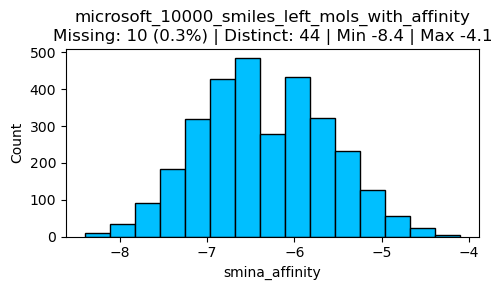

hiergraph_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 3396
  Valid: 3389
  Missing: 7 (0.21%)
  Distinct values: 50
  Minimum: -8.8
  Maximum: -3.7


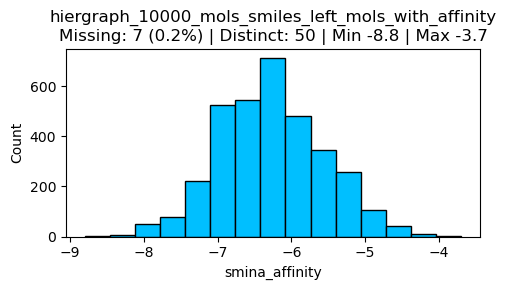

molgpt_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 2984
  Valid: 2979
  Missing: 5 (0.17%)
  Distinct values: 42
  Minimum: -8.5
  Maximum: -4.2


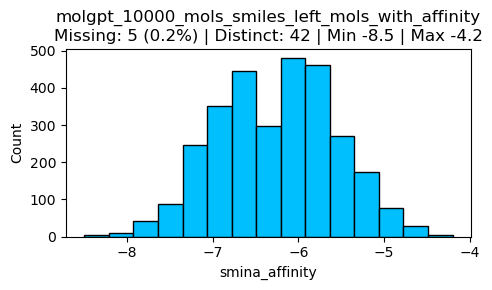

pocket2mol_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 1552
  Valid: 1552
  Missing: 0 (0.00%)
  Distinct values: 42
  Minimum: -9.0
  Maximum: -4.5


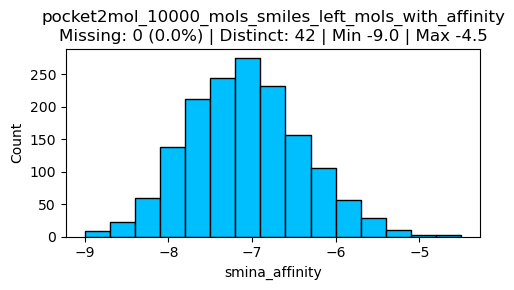

molfinder_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 2503
  Valid: 2482
  Missing: 21 (0.84%)
  Distinct values: 39
  Minimum: -8.3
  Maximum: -4.2


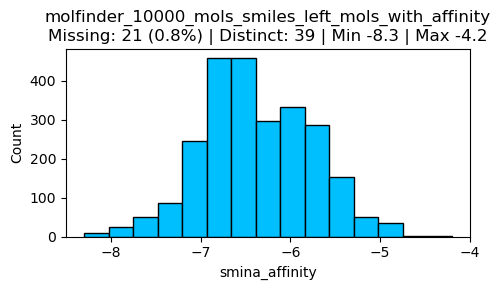

edm_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 404
  Valid: 194
  Missing: 210 (51.98%)
  Distinct values: 31
  Minimum: -7.5
  Maximum: -4.1


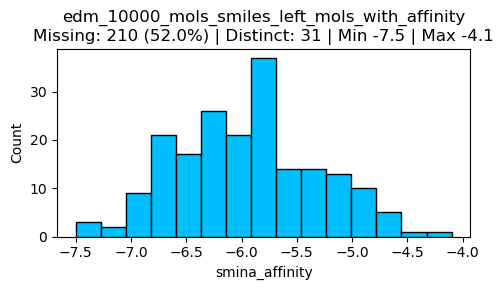

dragonfly_biased_smiles_left_mols_with_affinity.csv:
  Total: 2
  Valid: 2
  Missing: 0 (0.00%)
  Distinct values: 2
  Minimum: -6.3
  Maximum: -6.0


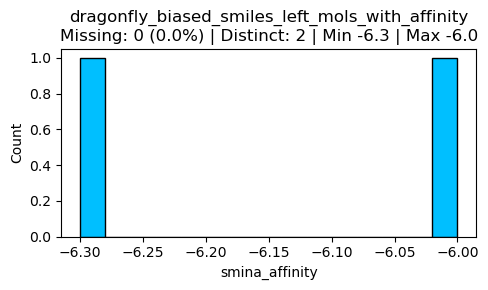

reinvent4_TL584_chpt200_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 1032
  Valid: 1028
  Missing: 4 (0.39%)
  Distinct values: 40
  Minimum: -9.2
  Maximum: -4.4


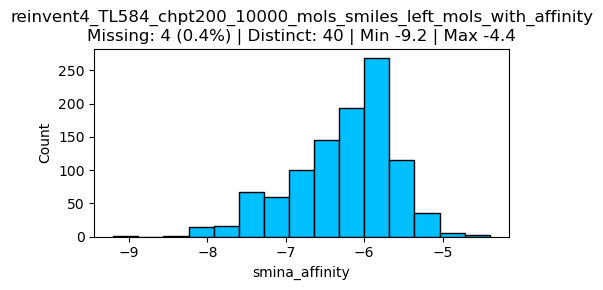

pilot_10000_smiles_left_mols_with_affinity.csv:
  Total: 2364
  Valid: 2362
  Missing: 2 (0.08%)
  Distinct values: 44
  Minimum: -9.0
  Maximum: -4.5


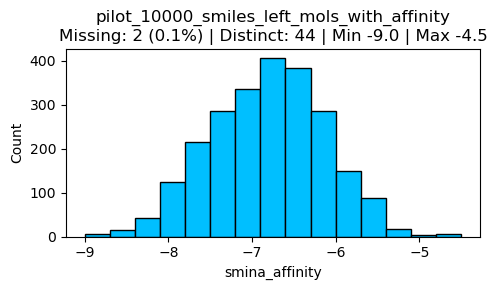

reinvent4_vanilla_with_affinity.csv:
  Total: 3893
  Valid: 3799
  Missing: 94 (2.41%)
  Distinct values: 46
  Minimum: -8.7
  Maximum: -4.1


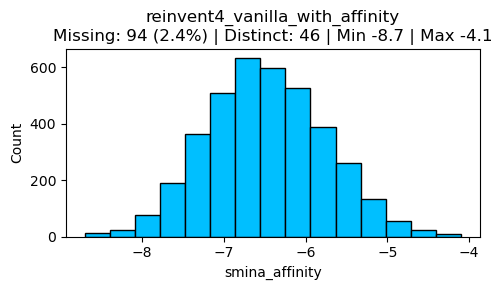

resgen_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 470
  Valid: 470
  Missing: 0 (0.00%)
  Distinct values: 32
  Minimum: -8.8
  Maximum: -5.4


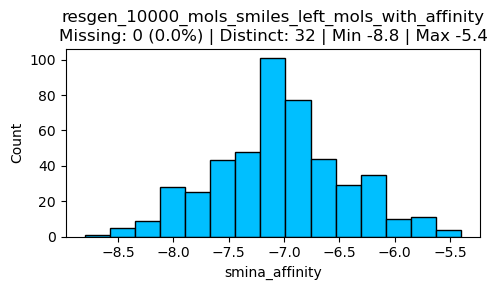

dragonfly_unbiased_smiles_left_mols_with_affinity.csv:
  Total: 2015
  Valid: 2013
  Missing: 2 (0.10%)
  Distinct values: 42
  Minimum: -8.8
  Maximum: -4.7


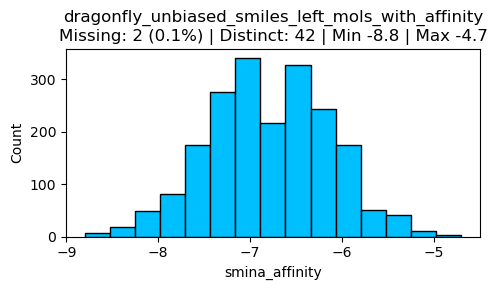

jtvae_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 5840
  Valid: 5825
  Missing: 15 (0.26%)
  Distinct values: 45
  Minimum: -8.9
  Maximum: -4.2


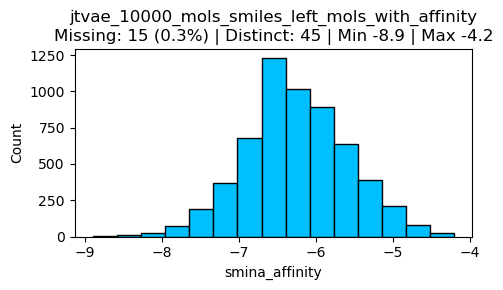

targetdiff_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 683
  Valid: 683
  Missing: 0 (0.00%)
  Distinct values: 36
  Minimum: -8.5
  Maximum: -4.6


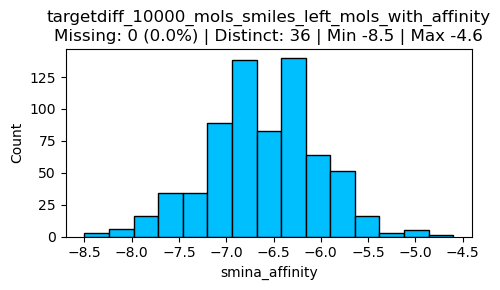

tgmdlm_10000_mols_smiles_left_mols_with_affinity.csv:
  Total: 675
  Valid: 644
  Missing: 31 (4.59%)
  Distinct values: 47
  Minimum: -8.6
  Maximum: -3.8


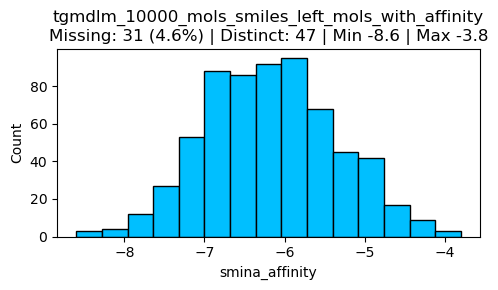

All histograms displayed.


In [9]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

result_dir = Path("left_molecules_with_affinity")
for csv_file in result_dir.glob("*_with_affinity.csv"):
    df = pd.read_csv(csv_file)
    vals = df["smina_affinity"]
    n_total = len(vals)
    n_missing = vals.isna().sum()
    n_valid = n_total - n_missing
    n_distinct = vals.nunique(dropna=True)
    vmin = vals.min()
    vmax = vals.max()
    print(f"{csv_file.name}:")
    print(f"  Total: {n_total}")
    print(f"  Valid: {n_valid}")
    print(f"  Missing: {n_missing} ({n_missing/n_total*100:.2f}%)")
    print(f"  Distinct values: {n_distinct}")
    print(f"  Minimum: {vmin}")
    print(f"  Maximum: {vmax}")


    plt.figure(figsize=(5, 3))
    vals.dropna().plot.hist(bins=15, color="deepskyblue", edgecolor="k")
    plt.title(f"{csv_file.stem}\n"
              f"Missing: {n_missing} ({n_missing/n_total*100:.1f}%) | Distinct: {n_distinct} "
              f"| Min {vmin:.1f} | Max {vmax:.1f}")
    plt.xlabel("smina_affinity")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

print("All histograms displayed.")
